# This is a SUPER rough draft as I put code vomit on a page; check back in a week it'll be nice and pretty (if not, @ me)

In [116]:
# https://github.com/dashee87/cryptory

In [117]:
import pandas as pd
import time
import datetime
import numpy as np
from fbprophet import Prophet

In [118]:
# load package
from cryptory import Cryptory

# initialise object 
# pull data from start of 2017 to present day
my_cryptory = Cryptory(from_date = "2015-01-01")

# get historical ethereum OHLC data from coinmarketcap
eth_ohlc_hist_df = my_cryptory.extract_coinmarketcap("ethereum")

# inspect the results
eth_ohlc_hist_df.head()

,date,open,high,low,close,volume,marketcap
0,2019-03-21,140.48,141.00,135.86,136.64,5087247796,14392427839
1,2019-03-20,140.48,140.95,138.31,140.69,4664134462,14817151375
2,2019-03-19,139.25,140.99,139.14,140.52,4251488129,14797612389
3,2019-03-18,140.10,142.27,138.84,139.37,4551739879,14675181094
4,2019-03-17,142.24,142.37,139.32,140.00,3827157729,14739201597


In [119]:
# subset to just the date and the closing price
eth_price_hist_df = my_cryptory.extract_coinmarketcap("ethereum").loc[:,['date','close']]

eth_price_hist_df = eth_price_hist_df.loc[eth_price_hist_df['date']>='01OCT2018',:]
# rename dt column to ds and continous value column to y per fbprophet's docs
eth_price_hist_df.columns = ['ds', 'y']

In [120]:
saturating_min = 0
saturating_max = 300

# eth_price_hist_df.loc[:,'floor'] = saturating_min
# eth_price_hist_df.loc[:,'cap'] = saturating_max

In [121]:
m = Prophet(
)
m.fit(eth_price_hist_df)

/Users/pauljeffries/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/pauljeffries/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [122]:
# Python
future = m.make_future_dataframe(periods=30)
# future.loc[:,'floor'] = saturating_min
# future.loc[:,'cap'] = saturating_max
future.tail()

,ds
197,2019-04-16
198,2019-04-17
199,2019-04-18
200,2019-04-19
201,2019-04-20


In [123]:
# Python
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
197,2019-04-16,142.142588,118.158233,165.951572
198,2019-04-17,142.688606,117.026551,167.020467
199,2019-04-18,138.996704,113.531266,165.382242
200,2019-04-19,141.087715,114.936593,165.895127
201,2019-04-20,143.089856,117.186143,167.832290


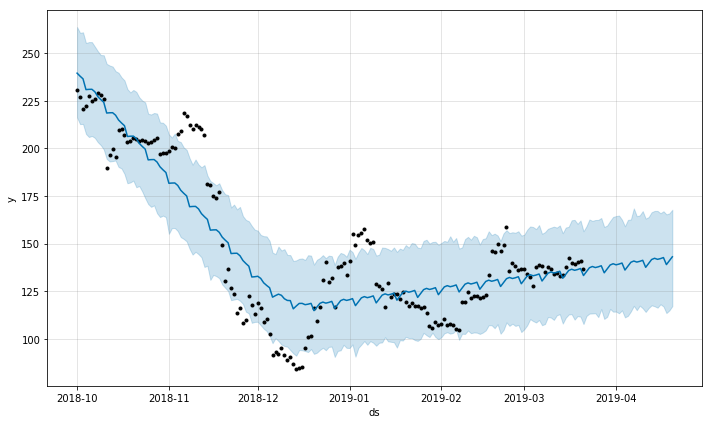

In [124]:
# Python
fig1 = m.plot(forecast)

In [125]:
%run -i 'prophet_helper_functions.py'

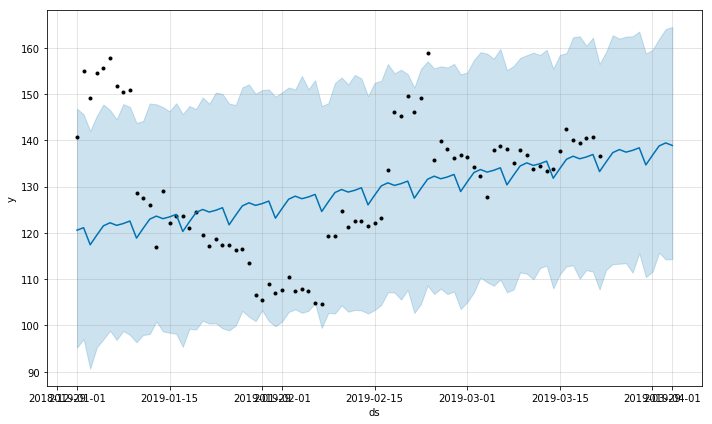

In [126]:
dt_restricted_prophet_plt(
    m = m,
    fcst = forecast,
    visible_window_start_dt = '01JAN2019',
    visible_window_end_dt = '01APR2019'
);

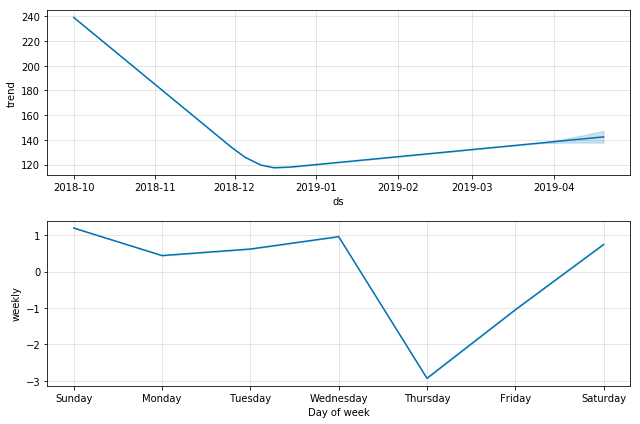

In [127]:
# Python
fig2 = m.plot_components(forecast)

In [128]:
%%capture
# capturing warnings here because one of the dependencies throws a bunch of numpy deprecation warnings

from fbprophet.diagnostics import cross_validation
df_dv = cross_validation(m, horizon = '30 days')

INFO:fbprophet:Making 4 forecasts with cutoffs between 2019-01-05 00:00:00 and 2019-02-19 00:00:00


In [129]:
df_dv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-01-06,124.426910,93.760067,153.863157,157.75,2019-01-05
1,2019-01-07,123.221009,94.626845,151.973284,151.70,2019-01-05
2,2019-01-08,123.750920,96.407275,153.444557,150.36,2019-01-05
3,2019-01-09,124.507062,97.731448,152.444545,150.80,2019-01-05
4,2019-01-10,120.322638,93.348082,149.147293,128.63,2019-01-05


In [130]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_dv)
df_p.head()

,horizon,mse,rmse,mae,mape,coverage
2,3 days,528.852118,22.996785,21.262133,0.155677,0.666667
63,4 days,437.268523,20.910967,18.766885,0.140436,0.750000
3,4 days,423.431650,20.577455,18.517903,0.138650,0.833333
93,4 days,540.628620,23.251422,20.855466,0.150600,0.750000
33,4 days,531.537973,23.055107,20.476312,0.147352,0.750000


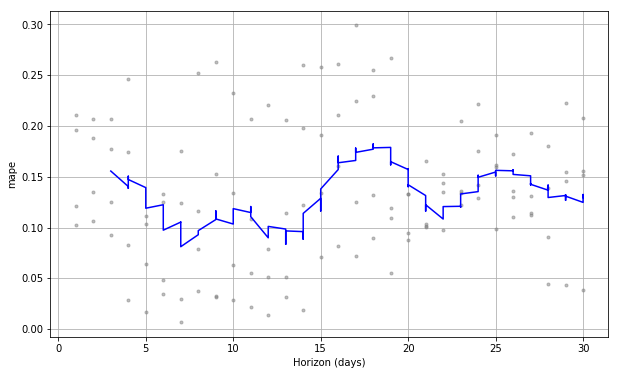

In [131]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_dv, metric = 'mape')